In [1]:
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModel = LensModel(lens_model_list=lens_model_list)
# python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import random
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

# lenstronomy imports
# Util
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.param_util as param_util
# Data
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# ImSim
from lenstronomy.ImSim.image_model import ImageModel
# SimAPI
from lenstronomy.SimulationAPI.sim_api import SimAPI
# LensModel
from lenstronomy.LensModel.lens_model import LensModel 
# LightModel
from lenstronomy.LightModel.light_model import LightModel
# Plots
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
# Workflow
from lenstronomy.Workflow.fitting_sequence import FittingSequence


In [2]:
# get filenames from desktop
#filepath = '/Users/gilliancartwright/Desktop/DES data/DES0038-4414/DESJ004037.4201-442615.0540/' # my personal filepath
#DES_4414_g = filepath + 'DESJ004037.4201-442615.0540_g.fits' # individual image names
#DES_4414_r = filepath + 'DESJ004037.4201-442615.0540_r.fits'
#DES_4414_i = filepath + 'DESJ004037.4201-442615.0540_i.fits'
#DES_4414_z = filepath + 'DESJ004037.4201-442615.0540_z.fits'

#def open_fits_image(filename): 
#    """Input a FITS filename and returns the SCI data"""
#    hdu = fits.open(filename)
#    data = hdu['SCI'].data
#    hdu.close()
#    return data

#i_data=open_fits_image(DES_4414_i) # grab i-band info
#i_image = i_data[27:87,27:87] # crop image


In [3]:
# magnification: 
#lensModel = LensModel(lens_model_list=lens_model_list)
#mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)



In [24]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width at half maximum of PSF
psf_type = 'GAUSSIAN' 

# Choices: (i think you are supposed to be able to get all of this from the data)
source_n_sersic = 1 # sersic index
lens_n_sersic = 2 
source_R_sersic = 0.1 # semi-major axis half light radius
lens_R_sersic = 0.6
#phi = 0.5, q = 0.7 # used to calculate e1 and e2 for source (i think i am somehow supposed to calculate this from the redshifts and data but idk how to)
redshift_list = [0.5,0.5] # lens redshift (SIE, SHEAR)

# parameters assumed for lens model:
# gamma1, gamma2
# e1, e2 for lens model



def simulate_image(theta_E, z_source, theta_ra, theta_dec, center_x, center_y):
    
    """
    Input: theta_E, 
    redshift of source (z_source), 
    position on image plane (theta_ra, theta_dec), 
    and center x,y
    
    Outputs: multi_band_list and kwargs_model, (image of simulation optional)
    
    """
    
    # lens model
    lens_model_list = ['SIE', 'SHEAR'] # list of lens models
    lens_model_class = LensModel(lens_model_list)
    lensModel = LensModel(lens_model_list=lens_model_list)
    
    
    # set kwargs_lens: 
    kwargs_sie = {'theta_E': theta_E, 'center_x': center_x, 'center_y': center_y, 'e1': .07, 'e2': -0.03}  # SIE parameters
    kwargs_lens = [kwargs_sie] 

    
    # add Shear
    #gamma1, gamma2 = lensModel.gamma(x, y, kwargs_lens) # x, y need to be numpy arrays
    #kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  # shear values for source plane
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0} # placeholder
    kwargs_lens.append(kwargs_shear)
    
    
    # psf
    kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
    
    
    # set kwargs_numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False} # kept supersampling_factor at 1 so it doesn't take as long

    
    # calculate source plane coords: 
    lensModel_mp = LensModel(lens_model_list=lens_model_list, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)
    beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens) 

    
    # calculate e1 and e2 given phi and q:
    e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)

    
    # Sersic parameters for the source
    kwargs_sersic = {'amp': 16, 'R_sersic': source_R_sersic, 'n_sersic': source_n_sersic, 'e1': -0.1, 'e2': 0.1, 'center_x': beta_ra, 'center_y': beta_dec} # SERSIC parameters
    source_model_list = ['SERSIC_ELLIPSE'] # light model for source
    kwargs_source = [kwargs_sersic] 
    source_model_class = LightModel(source_model_list)

    kwargs_sersic_lens = {'amp': 16, 'R_sersic': lens_R_sersic, 'n_sersic': lens_n_sersic, 'e1': e1, 'e2': e2, 'center_x': center_x, 'center_y': center_y}
    kwargs_lens_light = [kwargs_sersic_lens]
    lens_light_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_class = LightModel(lens_light_model_list)

    kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}
    
    
    # generate the coordinate grid and image properties (we only read out the relevant lines we need)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


    kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
                }
    
    data_class = ImageData(**kwargs_data)
    
    # generate the psf variables
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]] ####

    
    imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)
    
    # generate image
    image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

    poisson = image_util.add_poisson(image_model, exp_time=exp_time)
    bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
    image_sim = image_model + poisson + bkg

    data_class.update_data(image_sim)
    kwargs_data['image_data'] = image_sim


    def show_image(image_name):
        cmap = mpl.cm.get_cmap("gray").copy()
        cmap.set_bad(color='k', alpha=1.)
        cmap.set_under('k')

        f, ax = plt.subplots(figsize=(6, 6))

        im = ax.matshow(np.log10(image_name), origin='lower', vmin=-3, vmax=2, cmap=cmap, extent=[0, 1, 0, 1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.autoscale(False)
        plt.show()
        plt.close()
   
    #show_image(image_sim) if you want to show the simulated image first
    
    return multi_band_list, kwargs_model, theta_E, beta_ra, beta_dec, center_x, center_y

In [25]:
def model(multi_band_list, kwargs_model, kwargs_lens_params, kwargs_source_params, kwargs_lens_light_params):
    """
    Input multi_band_list, kwargs_model, lens, source, and lens-light params
    
    Output: observed image, modeled image, residuals 
    
    """
    # lens models
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append(kwargs_lens_params)
    kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens] # keep

    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []

    fixed_source.append({})
    kwargs_source_init.append(kwargs_source_params)
    kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []

    fixed_lens_light.append({})
    kwargs_lens_light_init.append(kwargs_lens_light_params)
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params, 'source_model': source_params, 'lens_light_model': lens_light_params}

    # Fitting Sequence (computing results)
    # if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
    kwargs_constraints = {}
    kwargs_likelihood = {'source_marg': False}
    
    
    fitting_seq = FittingSequence(kwargs_data_joint, # multi band list (kwargs_data['image_data'] = image_real, kwargs psf and kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False})
                              kwargs_model, # models
                              kwargs_constraints, # an empty dictionary??
                              kwargs_likelihood, # source_marg = False?
                              kwargs_params) # lens, source, and lens light params

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 100}], # itereations = 200 original
                       ['MCMC', {'n_burn': 100, 'n_run': 300, 'walkerRatio': 10, 'sigma_scale': .1}] # n_burn = 200 and n_run = 600 original
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    # plot model
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1])
    modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()




Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0113242687948991 reduced X^2 of best position
-1809.7647790084718 logL
3579 effective number of data points
[{'theta_E': 0.6876541983035809, 'e1': 0.04448689167513827, 'e2': -0.03959365282614589, 'center_x': 0.043443122906375, 'center_y': -0.06995704732337635}, {'gamma1': -0.09931741759616862, 'gamma2': 0.030090004259225627, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10648202587643092, 'n_sersic': 0.9643390521290258, 'e1': 0.1094594710500702, 'e2': 0.026346879394121153, 'center_x': 0.6167285026667942, 'center_y': 0.33968161472408614}] source result
[{'amp': 1, 'R_sersic': 0.6347754968143206, 'n_sersic': 2.0929593534863957, 'e1': 0.0994371485242613, 'e2': 0.14386310357608145, 'center_x': 0.05120980693570631, 'center_y': 0.0007351472475601647}] lens light result
[] point source result
{} special param result
29.354498147964478 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [01:41<00:00,  3.93it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 400
102.01614093780518 time taken for MCMC sampling
-1.0038377573697914 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0038377573697916


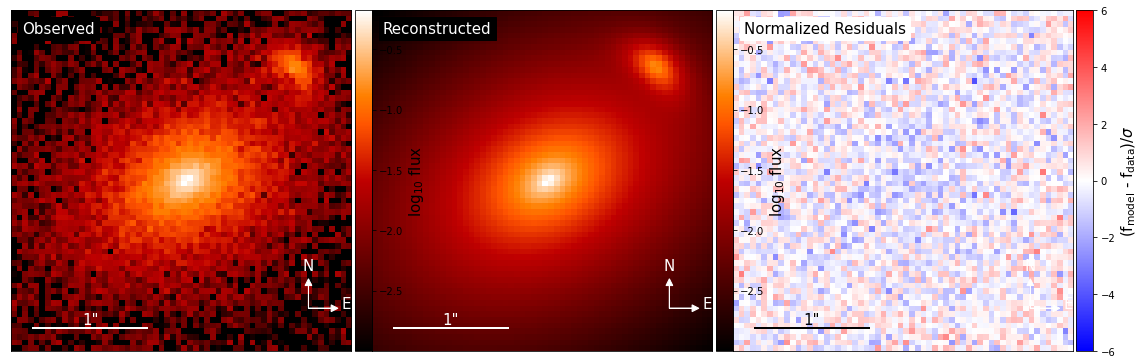

In [26]:
# initial


multi_band_list, kwargs_model, theta_E, beta_ra, beta_dec, center_x, center_y = simulate_image(theta_E = 0.7, z_source = 10, theta_ra = 1, theta_dec = 1, center_x = 0.05, center_y = 0)

kwargs_lp = {'theta_E': theta_E+random.uniform(-0.1, 0.1), 'e1': 0., 'e2': 0.,'center_x': center_x, 'center_y': center_y}
kwargs_sp = {'R_sersic': source_R_sersic+random.uniform(-0.1, 0.1), 'n_sersic': source_n_sersic, 'e1': 0, 'e2': 0, 'center_x': beta_ra, 'center_y': beta_dec}
kwargs_llp = {'R_sersic': lens_R_sersic+random.uniform(-0.1, 0.1), 'n_sersic': lens_n_sersic, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


model(multi_band_list, kwargs_model, kwargs_lp, kwargs_sp, kwargs_llp)
    

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0523217087250982 reduced X^2 of best position
-1883.1296977635634 logL
3579 effective number of data points
[{'theta_E': 0.7002628187124966, 'e1': 0.0633007940814376, 'e2': -0.027469694819393844, 'center_x': 0.0518580899145133, 'center_y': 5.7355616356575135e-05}, {'gamma1': -0.002845828849016773, 'gamma2': -0.04507980606646378, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09526435503406092, 'n_sersic': 0.9510712331370417, 'e1': -0.11734340512327991, 'e2': 0.07336853192471438, 'center_x': 0.07443324973137073, 'center_y': -0.023128723465363894}] source result
[{'amp': 1, 'R_sersic': 0.672663517675811, 'n_sersic': 2.1529451712729974, 'e1': 0.09562803325245876, 'e2': 0.14755087229323616, 'center_x': 0.05334667244136213, 'center_y': 0.002975534448601793}] lens light result
[] point source result
{} special param result
29.21937918663025 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [02:06<00:00,  3.17it/s]


Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 400
126.37849712371826 time taken for MCMC sampling
-1.046084243003227 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.046084243003227


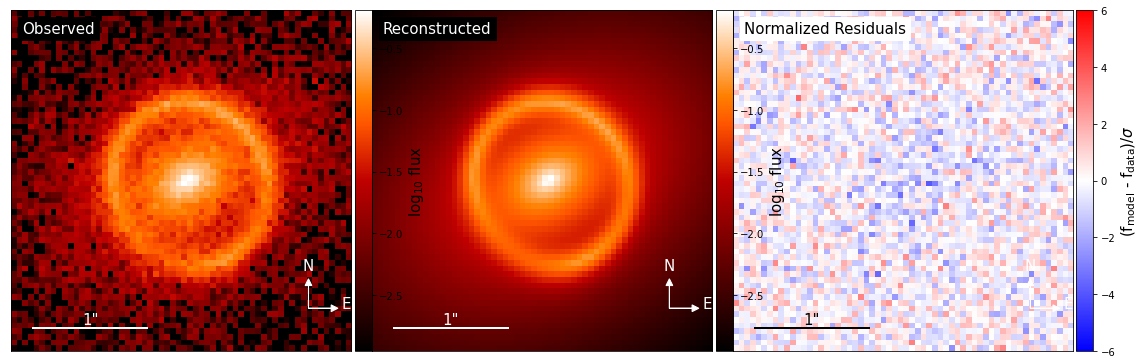

In [7]:
multi_band_list, kwargs_model, theta_E, beta_ra, beta_dec, center_x, center_y = simulate_image(theta_E = 0.7, z_source = 10, theta_ra = 0.5, theta_dec = 0.5, center_x = 0.05, center_y = 0)


kwargs_lp = {'theta_E': theta_E+random.uniform(-0.1, 0.1), 'e1': 0, 'e2': 0,'center_x': center_x, 'center_y': center_y}
kwargs_sp = {'R_sersic': source_R_sersic+random.uniform(-0.1, 0.1), 'n_sersic': source_n_sersic, 'e1': 0, 'e2': 0, 'center_x': beta_ra, 'center_y': beta_dec}
kwargs_llp = {'R_sersic': lens_R_sersic+random.uniform(-0.1, 0.1), 'n_sersic': lens_n_sersic, 'e1': 0, 'e2': 0, 'center_x': center_x, 'center_y': center_y}


model(multi_band_list, kwargs_model, kwargs_lp, kwargs_sp, kwargs_llp)